# Experiments with Telco Churn data

This notebook demonstrates how to build a ML model for telco churn data. We are going to build a basic model using scikit learn. The purpose is to experiment with feature engineering and different models. Once we are happy with the result we are going to package our code and execute this on AI platform training service.

In [1]:
# imports

#import google.auth
import dask.dataframe as dd
from google.cloud import bigquery, bigquery_storage
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt  
import pickle
from google.cloud import storage
from datetime import datetime
import os
import pandas as pd
import logging
import numpy
from typing import Union
import json

Here we set the PROJECT variable with your project id. The project id can be found on your GCP console but the following automates the process by getting the value from !gcloud config get-value project 

In [2]:
PROJECT=!gcloud config get-value project # returns default project id 
PROJECT=PROJECT[0]
DATASET='telco'
TABLE='churn'
BUCKET = "telco-churn"

DATA_GCS_LOCATION = "gs://"+BUCKET+"/data/data_v1.csv"

JOB_TIMESTAMP = datetime.now().strftime('%Y%m%d-%H%M%S')

# shortcut! AI Platform training creates this environment variable when you pass baseOutputDirectory with the training job.
# here I simulate this env variable but in actual training this will not be needed as it will be already created.
MODEL_DIR = "gs://"+BUCKET+"/training-"+JOB_TIMESTAMP

In [3]:
# feature categories

BINARY_FEATURES = [
    'gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'PhoneService',
    'PaperlessBilling']

NUMERIC_FEATURES = [
    'tenure',
    'MonthlyCharges',
    'TotalCharges']

CATEGORICAL_FEATURES = [
    'InternetService',
    'OnlineSecurity',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'Contract',
    'PaymentMethod',
    'MultipleLines']


ALL_COLUMNS = BINARY_FEATURES+NUMERIC_FEATURES+CATEGORICAL_FEATURES

BINARY_FEATURES_IDX = list(range(0,len(BINARY_FEATURES)))
NUMERIC_FEATURES_IDX = list(range(len(BINARY_FEATURES), len(BINARY_FEATURES)+len(NUMERIC_FEATURES)))
CATEGORICAL_FEATURES_IDX = list(range(len(BINARY_FEATURES+NUMERIC_FEATURES), len(ALL_COLUMNS)))

Before we start lets create a snaphop of our data in AI Platform Datasets. It is a good practice to keep a versioning visible in the UI. This dataset is only a reference to the CSV file and not replication of the data

In [ ]:
!pip install google-cloud-aiplatform

In [ ]:
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
from google.cloud import aiplatform

def create_dataset_tabular_gcs_sample(
    project: str,
    display_name: str,
    gcs_uri: str,
    location: str = "europe-west4",
    api_endpoint: str = "europe-west4-aiplatform.googleapis.com",
    timeout: int = 300,
):
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.DatasetServiceClient(client_options=client_options)
    metadata_dict = {"input_config": {"gcs_source": {"uri": [gcs_uri]}}}
    metadata = json_format.ParseDict(metadata_dict, Value())

    dataset = {
        "display_name": display_name,
        "metadata_schema_uri": "gs://google-cloud-aiplatform/schema/dataset/metadata/tabular_1.0.0.yaml",
        "metadata": metadata,
    }
    parent = f"projects/{project}/locations/{location}"
    response = client.create_dataset(parent=parent, dataset=dataset)
    print("Long running operation:", response.operation.name)
    return response.result(timeout=timeout)

resp = create_dataset_tabular_gcs_sample(PROJECT,DATASET+"-"+TABLE+"-v1", DATA_GCS_LOCATION)

## Loading data from BigQuery to Pandas Dataframe

In the following cell we are pulling data from BQ and loading them to a dataframe. Keep in mind that data might not fit your instance memory and therefore we might need to only bring a sample of the data. That is not a big problem as we are only experimenting. When we will be running our training job on AI Platform training we need to pick the right instance with enough memory.

Additionally our telco dataset fits the memory so we will go ahead and load everything.

In [4]:
def load_data_from_gcs(data_gcs_path: str) -> pd.DataFrame:
    # using dask that supports wildcards to read multiple files. then with .compute i create a pandas dataframe
    # some values for TotalCharges are missing and this creates confusion reading the data types. we define TotalCharges as object. 
    # we will later fix this upnormality
    logging.info("reading gs data: {}".format(data_gcs_path))
    return dd.read_csv(data_gcs_path, dtype={'TotalCharges': 'object'}).compute()

def load_data_from_bq(bq_uri: str) -> pd.DataFrame:
    logging.info("reading bq data: {}".format(bq_uri))
    project,dataset,table =  bq_uri.split(".")
    bqclient = bigquery.Client(project=PROJECT)
    bqstorageclient = bigquery_storage.BigQueryReadClient()
    query_string = """
    SELECT * from {ds}.{tbl}
    """.format(ds=dataset, tbl=table)

    return (
        bqclient.query(query_string)
        .result()
        .to_dataframe(bqstorage_client=bqstorageclient)
    )

In [89]:
df = load_data_from_gcs(DATA_GCS_LOCATION)

Let's have a look how the data loaded in the dataframe look like

In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,9732-OUYRN,Female,0,True,False,49,True,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,False,Credit card (automatic),19.0,918.7,False
1,0661-KQHNK,Female,0,True,True,6,True,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,False,Credit card (automatic),19.0,105.5,False
2,4709-LKHYG,Female,0,True,True,29,True,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,False,Electronic check,20.0,540.05,False
3,9824-QCJPK,Male,0,True,False,36,True,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,False,Mailed check,20.0,666.75,False
4,4716-MRVEN,Female,0,False,False,29,True,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,False,Mailed check,20.0,599.3,False


## Data Cleaning 

It seems that there are some invalid values in TotalCharges column where the TotalCharges is missing. Look at the first record below, data are order based on TotalCharges.

Why is that?

In [7]:
df.sort_values("TotalCharges", ascending=True)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2141,2775-SEFEE,Male,0,False,True,0,True,Yes,DSL,Yes,...,No,Yes,No,No,Two year,True,Bank transfer (automatic),61.90,,False
1478,2520-SGTTA,Female,0,True,True,0,True,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,False,Mailed check,20.00,,False
2241,4472-LVYGI,Female,0,True,True,0,False,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,True,Bank transfer (automatic),52.55,,False
1559,3115-CZMZD,Male,0,False,True,0,True,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,False,Mailed check,20.25,,False
2255,4075-WKNIU,Female,0,True,True,0,True,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,False,Mailed check,73.35,,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,8249-THVEC,Male,0,True,True,51,True,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,False,Mailed check,19.40,997.75,False
602,6051-PTVNS,Female,0,True,True,55,True,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,False,Credit card (automatic),19.15,998.1,False
3834,5899-MQZZL,Female,0,False,False,13,True,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,True,Mailed check,75.00,999.45,True
4165,4536-PLEQY,Male,0,True,False,12,True,No,Fiber optic,No,...,No,No,No,Yes,Month-to-month,True,Credit card (automatic),85.05,999.8,False


hm... I suspect that the reason is that new customers do not have TotalCharges as this is their first month...

In [8]:
df.loc[df['tenure']==0, ['tenure', 'MonthlyCharges', 'TotalCharges']]

,tenure,MonthlyCharges,TotalCharges
481,0,19.70,
1478,0,20.00,
1559,0,20.25,
1758,0,25.75,
2141,0,61.90,
2153,0,56.05,
2227,0,80.85,
2241,0,52.55,
2255,0,73.35,
2616,0,25.35,


Okey lets fix this by assigning the values of this column to the same as MonthlyCharges. For new customers at the end of the first month the total charges should be the same as that month

In [9]:
def sort_missing_total_charges(df: pd.DataFrame):
    df.loc[df.tenure == 0, 'TotalCharges'] = df.loc[df.tenure == 0, 'MonthlyCharges']

In [10]:
sort_missing_total_charges(df)
df.loc[df.tenure==0, ['tenure', 'MonthlyCharges', 'TotalCharges']]

,tenure,MonthlyCharges,TotalCharges
481,0,19.70,19.7
1478,0,20.00,20.0
1559,0,20.25,20.25
1758,0,25.75,25.75
2141,0,61.90,61.9
2153,0,56.05,56.05
2227,0,80.85,80.85
2241,0,52.55,52.55
2255,0,73.35,73.35
2616,0,25.35,25.35


We do not want all our columns. customerID is unique for every customer and does not provide any information for our model. Additionaly we want to separate the lable column from the training data.
Important to notice that we are also reordering the columns, Binary first, then the numeric and then the categorical ones.
This is the order that we will be accepting the features for prediction

In [11]:
def data_selection(df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    data = df.loc[:, ALL_COLUMNS]
    # We create a series with the prediciton label
    labels = df.Churn

    return data, labels

In [12]:
X, y = data_selection(df);

We need to split our data sto training and test sets and also select only the columns that we need to use in our training routine

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Feature Engineering
We have columns in multible formats. Some are numerical, some are binary categorical having only 2 values, and some are categorical with multiple options.
We are going to use OrdinalEncoder for the binary ones and OneHotEncoder for the multiple categories. 
Additionally we age going to use scaler for the numeric features.

We are going to perform opperations to our features, to OneHotEncode and to scaling to unit variance

In [14]:
def pipeline_builder(params_svm: dict) -> Pipeline:
    # Definining a preprocessing step for our pipeline. 
    # it specifies how the features are going to be transformed
    preprocessor = ColumnTransformer(
        transformers=[
            ('bin', OrdinalEncoder(), BINARY_FEATURES_IDX),
            ('num', StandardScaler(), NUMERIC_FEATURES_IDX),
            ('cat', OneHotEncoder(handle_unknown='ignore'), CATEGORICAL_FEATURES_IDX)])


    # We now create a full pipeline, for preprocessing and training.
    # for training we selected a linear SVM classifier
    
    clf = SVC()
    clf.set_params(**params_svm)
    
    return Pipeline(steps=[ ('preprocessor', preprocessor),
                          ('classifier', clf)])

We are going to split our data to  80% training and 20% test sets, and we will traing our model

In [66]:
model_params = {"kernel":"linear", "C":2, "class_weight":None}
clf = pipeline_builder(model_params)

## Training ML model
In the next step we are going to train our model and predict on the test data. We will then use the predictions to evaluate our model performance.

In [90]:
def train_model(clf: Pipeline, X: Union[pd.DataFrame, numpy.ndarray], y: Union[pd.DataFrame, numpy.ndarray]) -> float:
    # run cross validation to get training score. we can use this score to optimise training
    score = cross_val_score(clf, X, y, cv=10, n_jobs=-1).mean()
    
    # Now we fit all our data to the classifier. Shame to leave a portion of the data behind
    clf.fit(X, y)
    
    return score

In [78]:
cv_score = train_model(clf, X_train, y_train)

# Export Model to Cloud Storage

In [45]:
def process_gcs_uri(uri: str) -> (str, str, str, str):
    url_arr = uri.split("/")
    if "." not in url_arr[-1]:
        file = ""
    else:
        file = url_arr.pop()
    scheme = url_arr[0]
    bucket = url_arr[2]
    path = "/".join(url_arr[3:])
    path = path[:-1] if path.endswith("/") else path
    
    return scheme, bucket, path, file

In [46]:
def model_export_gcs(clf: Pipeline, model_dir: str) -> None:
    scheme, bucket, path, file = process_gcs_uri(model_dir)
    if scheme != "gs:":
            raise ValueError("URI scheme must be gs")
    
    # Upload the model to GCS
    bucket = storage.Client().bucket(bucket)
    blob = bucket.blob(os.path.join(path, 'model.pkl'))
    
    blob.upload_from_string(pickle.dumps(clf))

In [47]:
model_export_gcs(clf, MODEL_DIR)

## Evaluating model
What do you think of this model? Is it accurate enough? Shall we push it to production?

              precision    recall  f1-score   support

       False       0.84      0.89      0.86      1023
        True       0.65      0.54      0.59       386

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.73      1409
weighted avg       0.78      0.79      0.79      1409


 Confusion Matrix


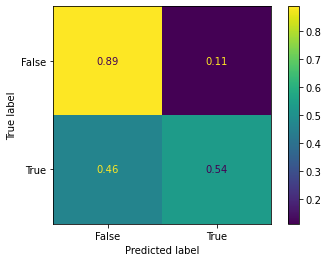

In [48]:
y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred))

print("\n Confusion Matrix")
plot_confusion_matrix(clf, X_test,y_test, normalize='true')
plt.show()

# Export Classification report

In [49]:
def report_export_gcs(report: str, model_dir: str) -> None:
    scheme, bucket, path, file = process_gcs_uri(model_dir)
    if scheme != "gs:":
            raise ValueError("URI scheme must be gs")
            
    # Upload the model to GCS
    bucket = storage.Client().bucket(bucket)
    blob = bucket.blob(os.path.join(path, 'report.txt'))
    
    blob.upload_from_string(report)

In [85]:
def prepare_report(cv_score: float, model_params: dict, classification_report: str, columns: list, example_data: numpy.ndarray) -> str:
    return """
Training Job Report    
    
Cross Validation Score: {cv_score}

Training Model Parameters: {model_params}
    
Test Data Classification Report:
{classification_report}

Example of data array for prediciton:

Order of columns:
{columns}

Example for clf.predict()
{predict_example}


Example of GCP API request body:
{{
    "instances": {json_example}
}}


Model parameters
""".format(
    cv_score=cv_score,
    model_params=json.dumps(model_params),
    classification_report=classification_report,
    columns = columns,
    predict_example = example_data,
    json_example = json.dumps(example_data.tolist()))

In [87]:
report = prepare_report(cv_score,
                        model_params,
                        classification_report(y_test,y_pred),
                        ALL_COLUMNS, 
                        X_test.to_numpy()[0:2])

report_export_gcs(report, MODEL_DIR)

print(report)


Training Job Report    
    
Cross Validation Score: 0.8003228021112833

Training Model Parameters: {"kernel": "linear", "C": 2, "class_weight": null}
    
Test Data Classification Report:
              precision    recall  f1-score   support

       False       0.84      0.89      0.86      1023
        True       0.65      0.54      0.59       386

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.73      1409
weighted avg       0.78      0.79      0.79      1409


Example of data array for prediciton:

Order of columns:
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'tenure', 'MonthlyCharges', 'TotalCharges', 'InternetService', 'OnlineSecurity', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod', 'MultipleLines']

Example for clf.predict()
[['Male' 0 True False True False 8 20.25 '158.35' 'No'
  'No internet service' 'No internet service' 'No internet

#### Pause... Reflect... and...
### GO BACK TO QWIKLABS :)